In [1]:
import glob
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from torchsummary import summary

import albumentations as A
from albumentations.pytorch import ToTensorV2

import numpy as np
import xml.etree.ElementTree as ET

from copy import deepcopy

In [2]:
root_dir = './datasets/dogs'
img_dir = '/images/Images/'
annot_dir = '/annotations/Annotation/'

In [3]:
import os

labels_map = {}
for i, item in enumerate(os.listdir(root_dir + img_dir)):
    sub_folder = os.path.join(root_dir + img_dir, item)
    labels_map[sub_folder.split('-', maxsplit=1)[1]] = i

In [4]:
def img_crop(annot_path, img, crop):
    tree = ET.parse(annot_path)
    obj = tree.find('./object')
    bndbox = obj.find('bndbox')

    # 강아지 종류
    species = obj.find('name').text

    # 이미지에서의 강아지 위치
    xmin = int(bndbox.find('xmin').text)
    ymin = int(bndbox.find('ymin').text)
    xmax = int(bndbox.find('xmax').text)
    ymax = int(bndbox.find('ymax').text)

    label = labels_map.get(species)
    
    if crop:
        cropped_img = img[ymin:ymax, xmin:xmax]
        return label, cropped_img
    else:
        rectangle = [xmin, ymin, xmax, ymax]
        return label, img, rectangle

In [5]:
def getRectangle(img, rectangle):
    img = cv2.rectangle(img, (rectangle[0], rectangle[1]), 
                        (rectangle[2], rectangle[3]),
                 color=[255,0,0], thickness=3)
    return img

In [6]:
class DogsDataset(Dataset):
    def __init__(self, annot_dir, img_dir, transform=None, crop=True):
        self.annot_dir = glob.glob(root_dir + annot_dir + '*/*')
        self.img_dir = glob.glob(root_dir + img_dir + '*/*.jpg')
        self.transform = transform
        self.crop = crop
        
    def __len__(self):
        return len(self.img_dir)
        
    def __getitem__(self, idx):
        annot_path = self.annot_dir[idx]
        img_path = self.img_dir[idx]
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.crop:
            label, img = img_crop(annot_path, img, True)
        else:
            label, img, rectangle = img_crop(annot_path, img, False)
            img = getRectangle(img, rectangle)
            
        if self.transform is not None:
            img = self.transform(image=img)
            img['label'] = label
            return img

        sample = {'image': img, 'label': label}
        return sample

In [7]:
transformer = A.Compose([
    A.Resize(224,224),
    A.Normalize(),
    ToTensorV2()
])

In [8]:
total_dataset = DogsDataset(annot_dir=annot_dir,
                           img_dir=img_dir,
                           transform=transformer, crop=True)

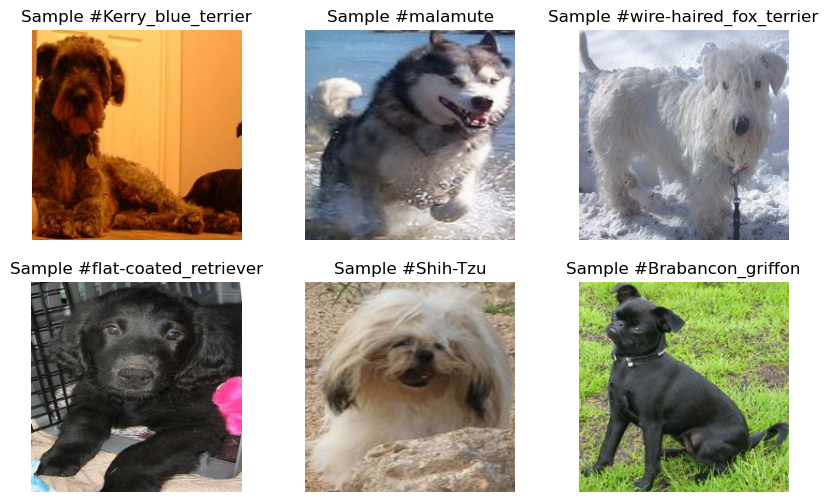

In [9]:
figure, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))
axes = axes.flatten()

for i in range(6):
    rand_i = np.random.randint(0, len(total_dataset))
    sample = total_dataset[rand_i]
    image = sample['image'].permute(1, 2, 0)
    label = sample['label']
    
    idx = list(labels_map.values())[label]
    name = list(labels_map.keys())[idx]
    
    mean=torch.tensor([0.485, 0.456, 0.406]) 
    std=torch.tensor([0.229, 0.224, 0.225])
    image.mul_(std)
    image.add_(mean)
    
    axes[i].axis('off')
    axes[i].imshow(image)
    axes[i].set_title('Sample #{}'.format(name))

In [10]:
total_dataset2 = DogsDataset(annot_dir=annot_dir,
                           img_dir=img_dir,
                           transform=transformer, crop=False)

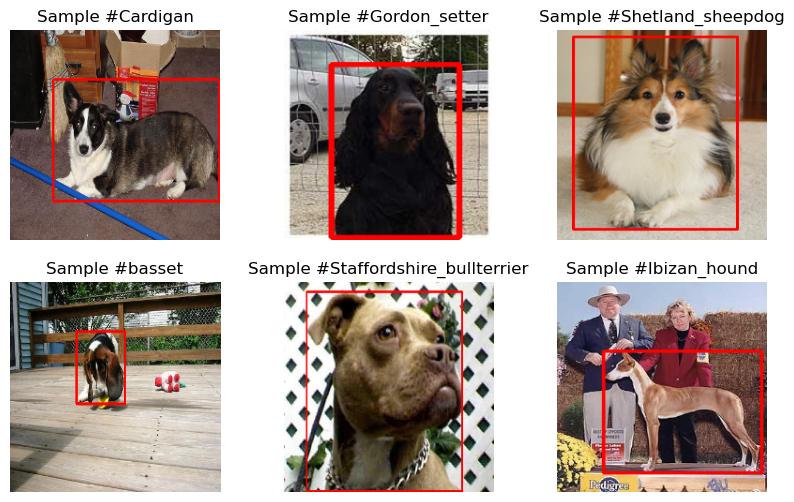

In [11]:
figure, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))
axes = axes.flatten()

for i in range(6):
    rand_i = np.random.randint(0, len(total_dataset2))
    sample = total_dataset2[rand_i]
    image = sample['image'].permute(1, 2, 0)
    label = sample['label']
    
    idx = list(labels_map.values())[label]
    name = list(labels_map.keys())[idx]
    
    mean=torch.tensor([0.485, 0.456, 0.406]) 
    std=torch.tensor([0.229, 0.224, 0.225])
    image.mul_(std)
    image.add_(mean)
    
    axes[i].axis('off')
    axes[i].imshow(image)
    axes[i].set_title('Sample #{}'.format(name))

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

total_label = [data['label'] for data in total_dataset]

trainset_idx, testset_idx = train_test_split(range(len(total_dataset)),
                test_size=0.2, random_state=42, shuffle=True, stratify=total_label)

train_set_ = Subset(total_dataset, trainset_idx)

train_label = [data['label'] for data in train_set_]

trainset_idx, validset_idx = train_test_split(range(len(trainset_idx)),
                test_size=0.2, random_state=42, shuffle=True, stratify=train_label)

In [ ]:
train_set = Subset(train_set_, trainset_idx)
test_set = Subset(total_dataset, testset_idx)
valid_set = Subset(train_set_, validset_idx)

In [65]:
def img_crop(annot_path, img):
    tree = ET.parse(annot_path)
    obj = tree.find('./object')
    bndbox = obj.find('bndbox')

    # 강아지 종류
    species = obj.find('name').text

    # 이미지에서의 강아지 위치
    xmin = int(bndbox.find('xmin').text)
    ymin = int(bndbox.find('ymin').text)
    xmax = int(bndbox.find('xmax').text)
    ymax = int(bndbox.find('ymax').text)

    label = labels_map.get(species)

    cropped_img = img[ymin:ymax, xmin:xmax]
    rectangle = [xmin, ymin, xmax, ymax]
    return label, cropped_img, rectangle

In [99]:
def getRectangle(img_, rectangle):
    res = cv2.rectangle(img_, (rectangle[0], rectangle[1]), 
                        (rectangle[2], rectangle[3]),
                 color=[255,0,0], thickness=3)
    return res

In [125]:
class DogsDataset(Dataset):
    def __init__(self, annot_dir, img_dir, transform=None):
        self.annot_dir = glob.glob(root_dir + annot_dir + '*/*')
        self.img_dir = glob.glob(root_dir + img_dir + '*/*.jpg')
        self.transform = transform
        self.rectangle_img = None
        
    def __len__(self):
        return len(self.img_dir)
        
    def __getitem__(self, idx):
        annot_path = self.annot_dir[idx]
        img_path = self.img_dir[idx]
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        label, cropped_img, rectangle = img_crop(annot_path, img)
        
        self.rectangle_img = getRectangle(img.copy(), rectangle)
        
        if self.transform is not None:
            res = self.transform(image=cropped_img)
            res['label'] = label
            return res

        res = {'image': cropped_img, 'label': label}
        return res
    
    def getRectangle(self, idx):
        self.__getitem__(idx)
        return self.rectangle_img

In [126]:
transformer = A.Compose([
    A.Resize(224,224),
    A.Normalize(),
    ToTensorV2()
])

In [127]:
total_dataset = DogsDataset(annot_dir=annot_dir,
                           img_dir=img_dir,
                           transform=transformer)

In [128]:
total_dataset[20]

{'image': tensor([[[-0.2171,  0.2453,  0.2111,  ..., -0.0458,  0.1083,  0.0056],
          [-0.1999,  0.2111,  0.3481,  ...,  0.0056,  0.2111,  0.0741],
          [-0.1657,  0.1768,  0.5193,  ...,  0.0569,  0.3823,  0.1597],
          ...,
          [-0.1486, -0.1657, -0.0287,  ...,  0.8276,  0.6563,  0.6392],
          [-0.1143, -0.1657,  0.0398,  ...,  0.9817,  0.6734,  0.5193],
          [-0.0972, -0.1657,  0.0741,  ...,  1.0844,  0.6906,  0.4337]],
 
         [[-0.0924,  0.3803,  0.3627,  ...,  0.1001,  0.2577,  0.1527],
          [-0.0749,  0.3452,  0.4853,  ...,  0.1352,  0.3627,  0.2052],
          [-0.0399,  0.3102,  0.6779,  ...,  0.1702,  0.5028,  0.2927],
          ...,
          [-1.0028, -1.0378, -0.9153,  ...,  0.9055,  0.7304,  0.7129],
          [-0.9503, -1.0203, -0.8452,  ...,  1.0630,  0.7479,  0.5903],
          [-0.9153, -0.9853, -0.7927,  ...,  1.1681,  0.7654,  0.5028]],
 
         [[-0.0092,  0.4439,  0.4614,  ...,  0.2348,  0.3916,  0.2871],
          [ 0.0082,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


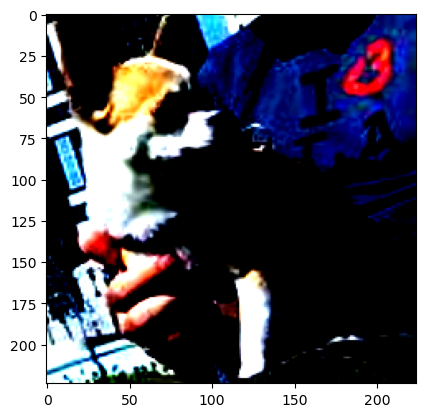

In [129]:
plt.imshow(total_dataset[120]['image'].permute(1,2,0))

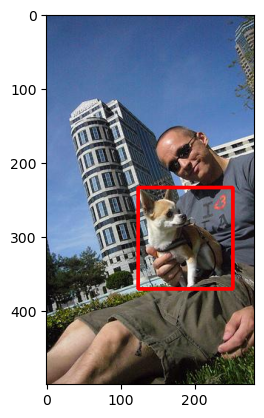

In [130]:
plt.imshow(total_dataset.getRectangle(120))